In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
%matplotlib inline

In [22]:
occ_by_ind

,NAICS_TITLE,OCC_CODE,OCC_TITLE,TOT_EMP,WL,NAICS,A_MEAN,EMP_PCT,WL_PCT
0,Dur,11-0000,Management Occupations,489090.0,6.807169e+10,33DG,NaN,0.054893,0.148072
1,Dur,13-0000,Business and Financial Operations Occupations,394910.0,3.311763e+10,33DG,NaN,0.044315,0.072038
2,Dur,15-0000,Computer and Mathematical Occupations,245210.0,2.780173e+10,33DG,NaN,0.053101,0.060475
3,Dur,17-0000,Architecture and Engineering Occupations,641020.0,5.878731e+10,33DG,NaN,0.266314,0.127876
4,Dur,19-0000,"Life, Physical, and Social Science Occupations",31470.0,2.491280e+09,33DG,NaN,0.024924,0.005419
...,...,...,...,...,...,...,...,...,...
15499,"Federal, State, and Local Government, excludin...",45-0000,"Farming, Fishing, and Forestry Occupations",20570.0,9.248272e+08,99,44960.0,0.046022,0.001410
15516,"Federal, State, and Local Government, excludin...",47-0000,Construction and Extraction Occupations,444400.0,2.402871e+10,99,54070.0,0.075979,0.036630
15589,"Federal, State, and Local Government, excludin...",49-0000,"Installation, Maintenance, and Repair Occupations",411030.0,2.368766e+10,99,57630.0,0.073735,0.036110
15652,"Federal, State, and Local Government, excludin...",51-0000,Production Occupations,167960.0,9.936514e+09,99,59160.0,0.019976,0.015148


In [23]:
occ_by_ind = pd.read_excel("../data/OES/natsector_M2021_dl.xlsx")
# A lot of total employment and wage estimates for "major" are showing up as unavailable. At some point we need 
# to estimate them from more granular occupation data
occ_by_ind = occ_by_ind[occ_by_ind['O_GROUP'] == 'major'][['NAICS', 'NAICS_TITLE', "OCC_CODE", "OCC_TITLE", "TOT_EMP", "A_MEAN"]]
occ_by_ind.loc[:, 'TOT_EMP'] = pd.to_numeric(occ_by_ind['TOT_EMP'], errors='coerce').fillna(0)
occ_by_ind.loc[:, 'A_MEAN'] = pd.to_numeric(occ_by_ind['A_MEAN'], errors='coerce').fillna(0)
occ_by_ind.loc[:, "WL"] = occ_by_ind.loc[:, 'TOT_EMP'] * occ_by_ind.loc[:, 'A_MEAN']
# Take out manufacturing and put in durable and nondurable manufacturing
occ_by_ind = occ_by_ind[occ_by_ind['NAICS'] != '31-33']

In [24]:
manu_dict = {'Nondur': list(range(311, 317)) + list(range(322, 327)),
             'Dur': [321, 327, 339] + list(range(331, 338))}
occ_3d = pd.read_excel("../data/OES/nat3d_M2021_dl.xlsx")
occ_3d = occ_3d[occ_3d['O_GROUP'] == 'major'][['NAICS', 'NAICS_TITLE', "OCC_CODE", "OCC_TITLE", "TOT_EMP", "A_MEAN"]]
occ_3d.loc[:, 'TOT_EMP'] = pd.to_numeric(occ_3d['TOT_EMP'], errors='coerce').fillna(0)
occ_3d.loc[:, 'A_MEAN'] = pd.to_numeric(occ_3d['A_MEAN'], errors='coerce').fillna(0)
occ_3d.loc[:, 'NAICS'] = occ_3d['NAICS'] // 1000

# Helper for retrieving industry names
def helper(x, manu_dict):
    for k, v in manu_dict.items():
        if x in v:
            return k
        else:
            None
occ_3d.loc[:, 'NAICS_TITLE'] = occ_3d['NAICS'].apply(lambda x: helper(x, manu_dict)).dropna()
occ_3d.loc[:, "WL"] = occ_3d.loc[:, 'TOT_EMP'] * occ_3d.loc[:, 'A_MEAN']

In [25]:
# aggregate 3-digit sectors to durable and nondurable and compute total employment and wage expenditures
occ_manu = occ_3d.dropna(subset=['NAICS_TITLE']).groupby(['NAICS_TITLE', 'OCC_CODE', 'OCC_TITLE']).agg({'TOT_EMP':'sum','WL':'sum'}).reset_index()
# assign naics codes
occ_manu.loc[:, "NAICS"] = occ_manu['NAICS_TITLE'].transform(lambda x: '33DG' if x == 'Dur' else '31ND')
occ_by_ind = pd.concat([occ_manu, occ_by_ind])
# compute employment share and wage expenditure share. Here the wage expenditure shares are not normalized by labor shares
occ_by_ind.loc[:, 'EMP_PCT'] = occ_by_ind['TOT_EMP']/occ_by_ind.groupby('OCC_CODE')['TOT_EMP'].transform(sum)
occ_by_ind.loc[:, 'WL_PCT'] = occ_by_ind['WL']/occ_by_ind.groupby('NAICS_TITLE')['WL'].transform(sum)
curlyL = occ_by_ind.pivot_table(columns=['OCC_TITLE'], index=['NAICS_TITLE'], values='EMP_PCT').fillna(0)
epsN = occ_by_ind.pivot_table(columns=['OCC_TITLE'], index=['NAICS_TITLE'], values='WL_PCT').fillna(0)

In [26]:
occ_by_ind['OCC_TITLE'].unique()

array(['Management Occupations',
       'Business and Financial Operations Occupations',
       'Computer and Mathematical Occupations',
       'Architecture and Engineering Occupations',
       'Life, Physical, and Social Science Occupations',
       'Community and Social Service Occupations', 'Legal Occupations',
       'Educational Instruction and Library Occupations',
       'Arts, Design, Entertainment, Sports, and Media Occupations',
       'Healthcare Practitioners and Technical Occupations',
       'Healthcare Support Occupations', 'Protective Service Occupations',
       'Food Preparation and Serving Related Occupations',
       'Building and Grounds Cleaning and Maintenance Occupations',
       'Personal Care and Service Occupations',
       'Sales and Related Occupations',
       'Office and Administrative Support Occupations',
       'Farming, Fishing, and Forestry Occupations',
       'Construction and Extraction Occupations',
       'Installation, Maintenance, and Repair 

In [27]:
index_dict = {'Food S':'Accommodation and Food Services', 'Rec':'Arts, Entertainment, and Recreation', 
                'Const':'Construction', 'Educ S':'Educational Services', 'Fin':'Finance and Insurance', 
                'Gov': 'Federal, State, and Local Government (excluding state and local schools and hospitals)', 
                'Health S':'Health Care and Social Assistance',
                'Info': 'Information', 'Mining':'Mining, Quarrying, and Oil and Gas Extraction', 
                'Manu': 'Manufacturing', 'Other S':'Other Services (except Public Administration)', 
                'Bus S': 'Professional, Scientific, and Technical Services', 
                'Real Est':'Real Estate and Rental and Leasing', 'Retail':'Retail Trade', 'Trans':'Transportation and Warehousing',
                'Whsale':'Wholesale Trade', 'Management':'Management of Companies and Enterprises',
                'Admin': 'Administrative and Support and Waste Management and Remediation Services', 
                'Agri': 'Agriculture, Forestry, Fishing and Hunting'}
occ_map = {'Architecture and Engineering Occupations': 'Eng', 
           'Arts, Design, Entertainment, Sports, and Media Occupations': 'Arts',
           'Building and Grounds Cleaning and Maintenance Occupations': 'Clean',
           'Business and Financial Operations Occupations': 'Bus Ops',
           'Community and Social Service Occupations': 'Soc S',
           'Computer and Mathematical Occupations': 'Math',
           'Construction and Extraction Occupations': 'Cons',
           'Educational Instruction and Library Occupations': 'Educ',
           'Farming, Fishing, and Forestry Occupations': 'Agg',
           'Food Preparation and Serving Related Occupations': 'Food S',
           'Healthcare Practitioners and Technical Occupations': 'Health P',
           'Healthcare Support Occupations': 'Health S', 
           'Installation, Maintenance, and Repair Occupations': 'Repair', 
           'Legal Occupations': 'Legal', 'Life, Physical, and Social Science Occupations':'Science',
           'Management Occupations': 'Manag', 'Office and Administrative Support Occupations': 'Admin',
           'Personal Care and Service Occupations': 'Care', 'Production Occupations': 'Prod',
           'Protective Service Occupations': 'Prot S', 'Sales and Related Occupations': 'Sales', 
           'Transportation and Material Moving Occupations': 'Trans'}
index_dict_swap = {v: k for k, v in index_dict.items()}
curlyL = curlyL.rename(index=index_dict_swap, columns=occ_map)
epsN = epsN.rename(index=index_dict_swap, columns=occ_map)

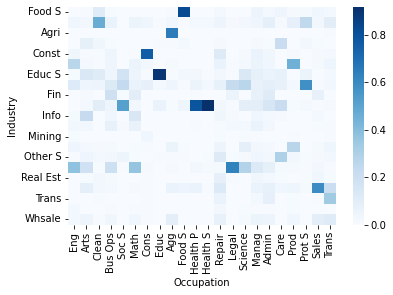

In [28]:
sns.heatmap(curlyL, cmap="Blues")
plt.xlabel('Occupation')
plt.ylabel('Industry')
plt.savefig('../output/figures/occupation_2021_heatmap.png', dpi=300)

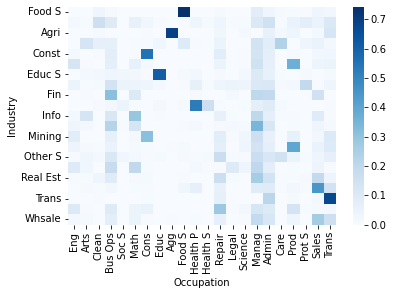

In [29]:
sns.heatmap(epsN, cmap="Blues")
plt.xlabel('Occupation')
plt.ylabel('Industry')
plt.savefig('../output/figures/epsN_2021_heatmap.png',dpi=300)

In [30]:
data_dir = '../data/clean/'
dfA      = pd.read_csv(data_dir + 'A.csv')
dfA.columns
dfA.index = dfA.BEA_sector
dfA = dfA.drop(labels=['BEA_sector'],axis=1)

In [31]:
sectors_dict = {'Food S':'Accommodation and food services','Rec':'Arts, entertainment, and recreation',
                'Const':'Construction','Dur':'Durable goods','Educ S':'Educational services','Fin':'Finance and insurance',
                'Gov':'Government','Health S':'Health care and social assistance','Info':'Information','Mining':'Mining',
                'Nondur':'Nondurable goods','Other S':'Other services, except government', 'Bus S':'Professional and business services',
                'Real Est':'Real estate and rental and leasing','Retail':'Retail trade','Trans':'Transportation and warehousing',
                'Whsale':'Wholesale trade'}
sector_dict_swap = {v: k for k, v in sectors_dict.items()}
dfA = dfA.rename(index=sector_dict_swap, columns=sector_dict_swap)

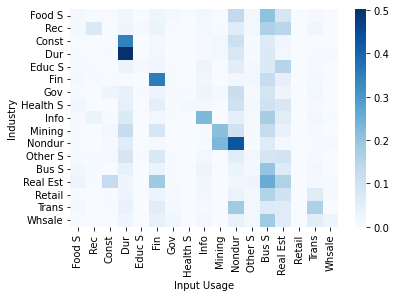

In [32]:
sns.heatmap(dfA, cmap="Blues")
plt.xlabel('Input Usage')
plt.ylabel('Industry')
plt.savefig('../output/figures/sectors_heatmap.png',dpi=300)

In [33]:
# Keep only the sectors we have data for
curlyL = curlyL[curlyL.index.isin(dfA.index)]
curlyL.rename(index=sectors_dict).sort_index().T.to_csv("../data/clean/curlyL_2021.csv")
epsN = epsN[epsN.index.isin(dfA.index)]
epsN.rename(index=sectors_dict).sort_index().to_csv("../data/clean/epsN_2021.csv")